# Introduction
Published articles including metadata has been scraped from the archive of Tagesschau.de. Articles are available for 2022. Each article posses tags which can be viewed as related topics. The intention of this analysis is to get a better understanding of the temporal evolution of topics throughout the year. Which topics were dominant throughout the year and which topics influence each other? A simple EDA will be carried out to answer fundamental questions and to derive fresh ideas for more advanced investigations.

In [1]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/tutorial/color_palettes.html
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set_theme(style="ticks")
sns.set_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

# Load the data
First, we need to connect to the database and load our dataset. Each record in the table ``Tagesschau`` represents one published article. We are interested in the temporal evolution of the article tags such that we are exclusively loading the ``timestamp``, and ``tags`` columns, where ``timestamp`` holds the publishing date and time information in the format ``YYYY-MM-DD HH:MM:SS``.

In [2]:
conn = sqlite3.connect("news.db")
cursor = conn.cursor()
columns_to_extract = ["timestamp", "tags"]
cursor.execute(f"SELECT {','.join(columns_to_extract)} FROM Tagesschau")
results = cursor.fetchall()

The output from the SQL query is saved into a pandas dataframe for further computations.

In [3]:
df_news = pd.DataFrame(results, columns=columns_to_extract)
df_news['timestamp'] = pd.to_datetime(df_news['timestamp'])
df_news.sort_values("timestamp", inplace=True)
df_news.reset_index(drop=True, inplace=True)

In [4]:
df_news

,timestamp,tags
0,2022-01-01 02:48:00,"Silvester,2021,Neujahr"
1,2022-01-01 03:07:00,"G7,Russland,China,Klima,Coronavirus"
2,2022-01-01 03:59:00,"Kulturhauptstadt,Kultur,Serbien"
3,2022-01-01 04:01:00,"Ipcioglu,Vierschanzentournee,Skispringen"
4,2022-01-01 07:14:00,"USA,New York,Eric Adams"
...,...,...
15741,2022-12-31 17:22:00,"Papst Benedikt XVI.,Vatikan,Papst"
15742,2022-12-31 18:21:00,"Ukraine,Angriffe,Russland,Kiew"
15743,2022-12-31 19:16:00,"Papst Benedikt XVI.,Reaktionen"
15744,2022-12-31 20:31:00,"Ukraine,Selenskyj,Russland"


It is important to note, that the timestamp column is of type datetime to perform aggregations on different time frequencies. 

In [5]:
df_news.dtypes

timestamp    datetime64[ns]
tags                 object
dtype: object

# Simple EDA (Exploratory Data Analysis) on tags
The main purpose for this simple EDA is to grasp an overall idea of the dataset. EDA is always a open-ended process of understanding the data. To minimize the chance to get lost in analyzing details, we start here with fundamental questions towards the dataset. This list is by no means exhaustive but the idea is to start the analysis in a systematic way. This approach seems to be obvious, however, at least I know from my experience that without fixing the target questions in the very beginning I end up with a completely unstructured notebook.

The questions can be grouped in three pillars, namely *missing data*, *article frequency*, *statistics on the article tags*.

## Missing data
1. How many missing values are in the dataset?
2. How many missing tags are in the dataset?

In [6]:
df_news.isna().sum()

timestamp    0
tags         0
dtype: int64

In [7]:
indices_to_drop = df_news.query("tags == ''").index
df_news.query("tags == ''")

,timestamp,tags
176,2022-01-05 16:57:00,
694,2022-01-17 15:26:00,
771,2022-01-18 21:29:00,
862,2022-01-20 14:47:00,
1565,2022-02-04 11:28:00,
...,...,...
15419,2022-12-22 13:52:00,
15479,2022-12-24 11:28:00,
15676,2022-12-29 20:48:00,
15693,2022-12-30 10:56:00,


Remove records where no tags are provided.

In [8]:
df_news.drop(index=indices_to_drop, inplace=True)
df_news.reset_index(drop=True, inplace=True)

## Article frequency
1. How many articles are published in 2022?
2. How are the articles distributed throughout the years?
3. Are there months where more articles are published than usual?

Let's start by aggregating the published articles on different sample frequency. We are calculating the number of published articles with a yearly, monthly and weekly frequency. This list can be easily extended by manipulating ``article_aggregation_options``. The full list of available frequency aliases which can be used in ``pd.Grouper`` can be found in https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [9]:
article_aggregation_options = {
    'name': ['yearly', 'monthly', 'weekly'],
    'column': ["numberArticlesPerYear", "numberArticlesPerMonth", "numberArticlesPerWeek"],
    'freq': ['1Y', '1M', '1W']
    }

aggregated_article_counts = {
    name: df_news.groupby(pd.Grouper(key="timestamp", freq=freq)).agg({'tags': 'count'}).rename(columns={'tags': column})\
        for (name, freq, column)\
        in zip(*[article_aggregation_options[key] for key in ['name', 'freq', 'column']])
    }

All aggregated dataframes are saved in a dictionary format. According to the definitions, we can access each aggregation through the list of available keys:

In [10]:
aggregated_article_counts.keys()

dict_keys(['yearly', 'monthly', 'weekly'])

The total number of published articles is retrieved by using the ``yearly`` key and it is a single number since we are only looking at data from 2022.

In [11]:
aggregated_article_counts['yearly']

,numberArticlesPerYear
timestamp,
2022-12-31,15671


To investigate how the published articles are distributed over the year, we are plotting the monthly and weekly published articles over the year, respectively. From the monthly data, we can see that there are no months with a dramatic low or high number of published articles. The number of published articles are ranging between 1178 and 1474, where the average number of articles is approximately 1312.

Text(0, 0.5, '# articles')

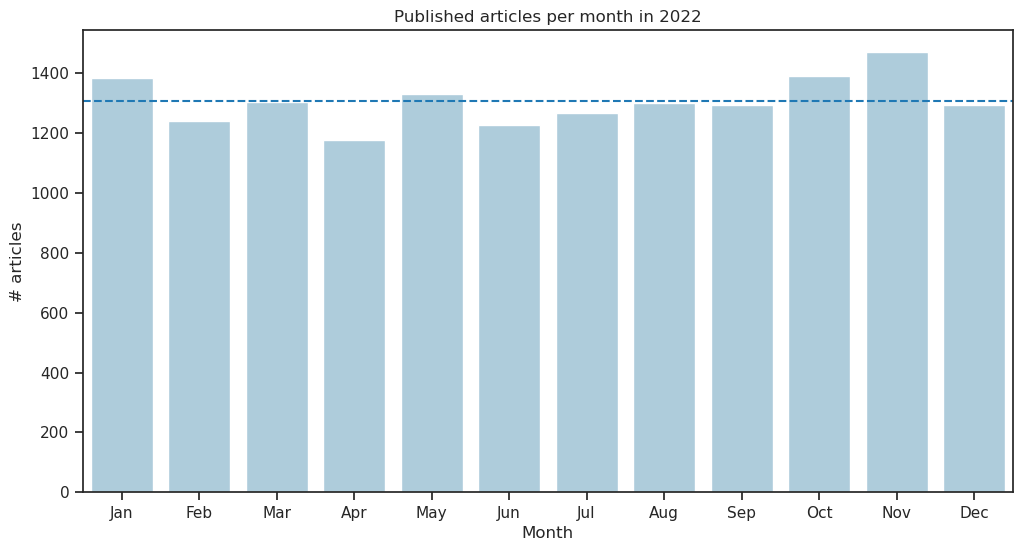

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
fig = sns.barplot(data=aggregated_article_counts['monthly'].reset_index(drop=False), x='timestamp', y='numberArticlesPerMonth', color='C0')
x_dates = aggregated_article_counts['monthly'].reset_index(drop=False)['timestamp'].dt.strftime('%b')
ax.set_xticklabels(labels=x_dates);
fig.axhline(y=float(aggregated_article_counts['monthly'].mean()), color='C1', linestyle='--')
plt.title("Published articles per month in 2022")
ax.set_xlabel("Month")
ax.set_ylabel("# articles")

The number of published articles per week shows also a relative constant distribution over the year. In the first and last week of 2022 the number of published articles is significantly lower compared to the average value. To effects come into play here. The first calendar week of 2022 has only 2 days. On the other hand, many people are on holiday in the last week of the year. 

Text(0, 0.5, '# articles')

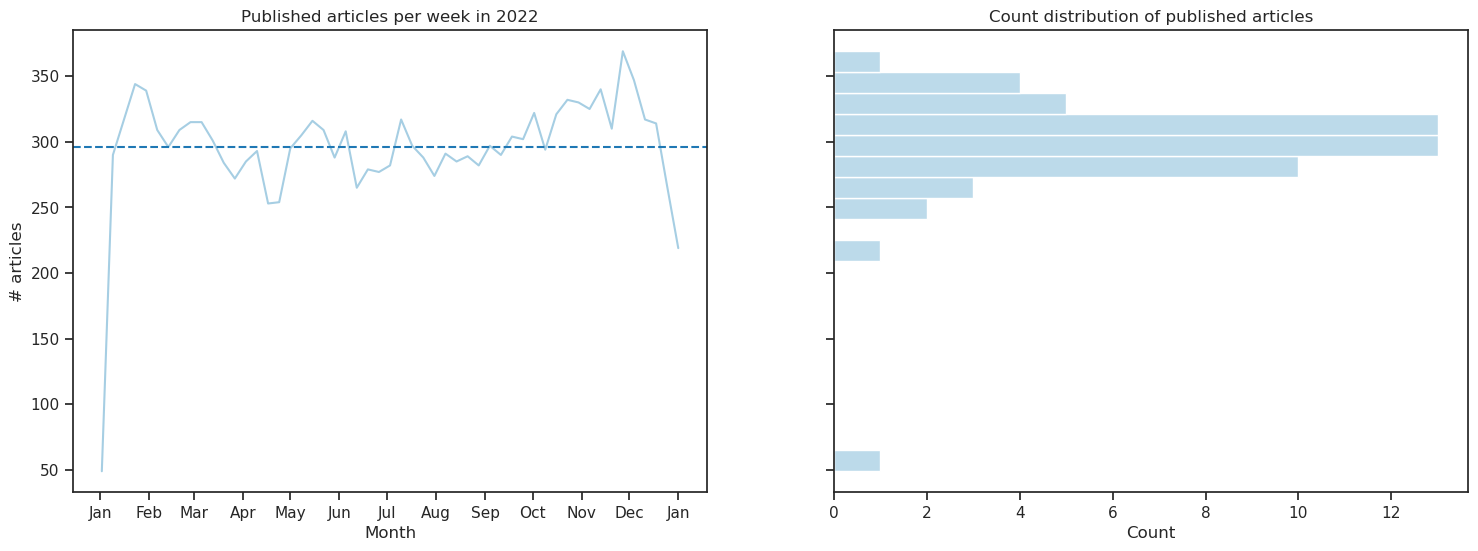

In [13]:

# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.MonthLocator
# https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(18, 6), ncols=2, sharey=True)
fig = sns.lineplot(data=aggregated_article_counts['weekly'], color='C0', legend=None, ax=ax[0])
sns.histplot(data=aggregated_article_counts['weekly'], y='numberArticlesPerWeek', ax=ax[1])
fig.axhline(y=float(aggregated_article_counts['weekly'].mean()), color='C1', linestyle='--')
date_form = DateFormatter("%b")
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].set_title("Published articles per week in 2022")
ax[1].set_title("Count distribution of published articles")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("# articles")


## Tags
1. How many tags are used per article?
2. How many unique tags are used in 2022?
3. What are the top tags used in 2022?
4. What are the top tags used per month?
5. How is the frequency of the top tags distributed over the year?
6. How are the tags correlated with respect to their occurrence (aggregated count)?

For processing the article tags, a conversion to a list of tags is necessary. This can be obtained by splitting the comma-separated ``tags`` column accordingly. 

In [14]:
df_news['tags_splitted'] = df_news['tags'].apply(lambda x: x.split(','))

### How many tags are used per article? 

Calculate the number of tags per article and plot the result in a count plot. The most common number of tags is 3, followed by 2 and 4. 

Text(0.5, 0, '# tags')

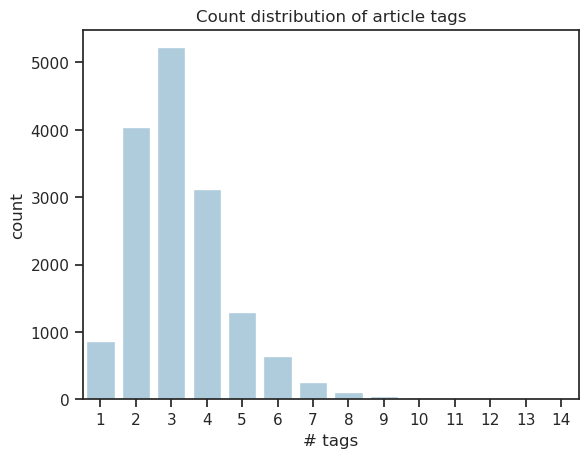

In [15]:
df_news['num_tags'] = df_news['tags_splitted'].apply(len)

fig, ax = plt.subplots()
sns.countplot(data=df_news, x='num_tags', color='C0', ax=ax)
ax.set_title("Count distribution of article tags")
ax.set_xlabel("# tags")

### How many unique tags are used in 2022?

Create a list for all tags in used in 2022. Note that ``all_tags`` contains duplicated entries when tags occur more then once, which is the case when we are looking at all article tags for 2022. From the raw list of all tags, a list of unique tags is derived by using the ``set()`` function. 

In [16]:
tag_aggregation_options = {
    'name': ['yearly', 'monthly'],
    'column': ["allTagsPerYear", "allTagsPerMonth"],
    'freq': ['1Y', '1M']
    }

summed_tags = {
    name: df_news.groupby(pd.Grouper(key="timestamp", freq=freq)).agg({'tags_splitted': 'sum'}).rename(columns={'tags_splitted': column})\
        for (name, freq, column)\
        in zip(*[tag_aggregation_options[key] for key in ['name', 'freq', 'column']])
    }

In [17]:
summed_tags['yearly']['allTagsPerYear'].apply(lambda x: len(list(set(x))))

timestamp
2022-12-31    9070
Freq: A-DEC, Name: allTagsPerYear, dtype: int64

### What are the top tags used in 2022?

In [18]:
for name, column in zip(tag_aggregation_options['name'], tag_aggregation_options['column']):
    summed_tags[name]['tags_frequency'] = summed_tags[name][column].apply(Counter)

In [19]:
def get_top_n_tag_counts(tag_frequency, top_n, frequency, date):
    if frequency == "monthly":
        mask = (tag_frequency.index.month == date['month']) & (tag_frequency.index.year == date['year'])
    elif frequency == "yearly":
        mask = tag_frequency.index.year == date['year']
    if any(mask):
        top_n_tags = tag_frequency[mask]['tags_frequency'].apply(lambda c: c.most_common(top_n)).item()
        return pd.DataFrame(top_n_tags, columns=['tag', 'count'])
    else:
        raise ValueError(f"No data available for date {date}")
        

In [20]:
df_top_n_tags_for_2022 = get_top_n_tag_counts(summed_tags['yearly'], top_n=15, frequency="yearly", date=dict(year=2022))
df_top_n_tags_for_2022

,tag,count
0,Ukraine,2644
1,Russland,1527
2,Coronavirus,1103
3,USA,663
4,Energiekrise,525
5,EU,472
6,Ukraine-Krieg,437
7,China,425
8,Liveblog,405
9,Inflation,404


Text(0.5, 1.0, 'Count distribution of top tags in 2022')

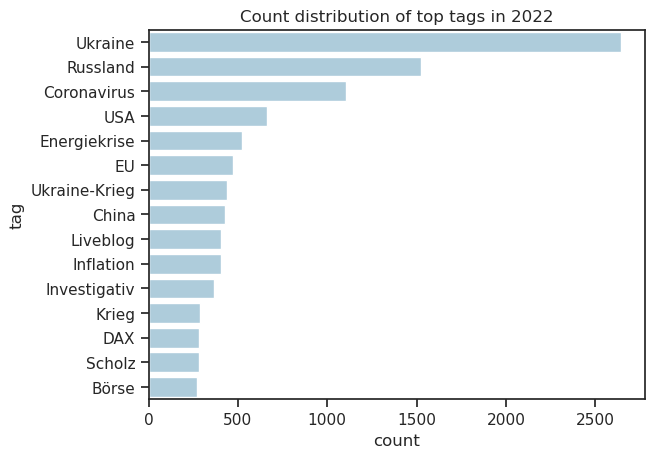

In [21]:
fig, ax = plt.subplots()
fig = sns.barplot(
    data=df_top_n_tags_for_2022,
    y='tag',
    x='count',
    color='C0'
)
ax.set_title("Count distribution of top tags in 2022")

### What are the top tags used per month?

In [22]:
import calendar

In [23]:
df_top_n_tags_for_jan_2022 = get_top_n_tag_counts(summed_tags['monthly'], top_n=5, frequency="monthly", date=dict(year=2022, month=1))
df_top_n_tags_for_jan_2022

,tag,count
0,Coronavirus,274
1,Ukraine,99
2,Russland,89
3,USA,71
4,Corona-Pandemie,48


Text(0.5, 1.0, 'Count distribution of top tags in January 2022')

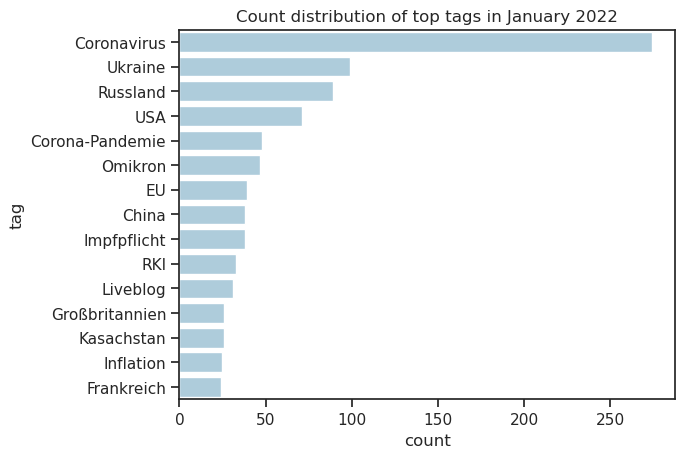

In [24]:
date = {'year': 2022, 'month': 1}

fig, ax = plt.subplots()
fig = sns.barplot(
    data=get_top_n_tag_counts(summed_tags['monthly'], top_n=15, frequency="monthly", date=date),
    y='tag',
    x='count',
    color='C0'
)
ax.set_title(f"Count distribution of top tags in {calendar.month_name[date['month']]} {date['year']}")

### How is the frequency of the top tags distributed over the year?

In [25]:
# Temporal distribution of tag occurrence 
df_tags_occurrence = pd.DataFrame()
for tag in df_top_n_tags_for_2022['tag']:
    df_tags_occurrence = pd.concat([
        df_tags_occurrence,
        df_news\
            .set_index('timestamp')['tags_splitted']\
            .apply(lambda x: 1 if tag in x else 0)\
            .groupby(pd.Grouper(freq="2W"))\
            .sum()\
            .rename(tag)
        ],axis=1
    )

In [26]:
df_tags_occurrence.head()

,Ukraine,Russland,Coronavirus,USA,Energiekrise,EU,Ukraine-Krieg,China,Liveblog,Inflation,Investigativ,Krieg,DAX,Scholz,Börse
2022-01-02 00:00:00,1,1,10,2,0,5,0,1,2,1,0,0,0,0,0
2022-01-16 00:00:00,25,31,131,32,0,14,0,17,14,16,9,0,11,4,10
2022-01-30 00:00:00,68,52,124,35,0,20,0,19,14,6,11,0,9,1,8
2022-02-13 00:00:00,55,48,120,35,0,20,0,17,14,15,12,0,13,16,12
2022-02-27 00:00:00,198,165,88,27,0,34,4,12,20,13,18,36,12,19,5


In [27]:
df_tags_rel_occurrence = df_tags_occurrence / df_tags_occurrence.sum()

def plot_rel_count_for_tags(df):
    fig, ax = plt.subplots(figsize=(12,6))
    fig = sns.lineplot(data=df, dashes=False)
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_title("Normalized counted tag usage for every two weeks")
    ax.set_xlabel("Month")
    ax.set_ylabel("Relative count")
    # xmax = df_tags_rel_occurrence['Energiekrise'].idxmax()
    # ymax = df_tags_rel_occurrence.loc[xmax, 'Energiekrise']
    # ax.annotate(xmax.date(), xy=(xmax, ymax),  xycoords='data')

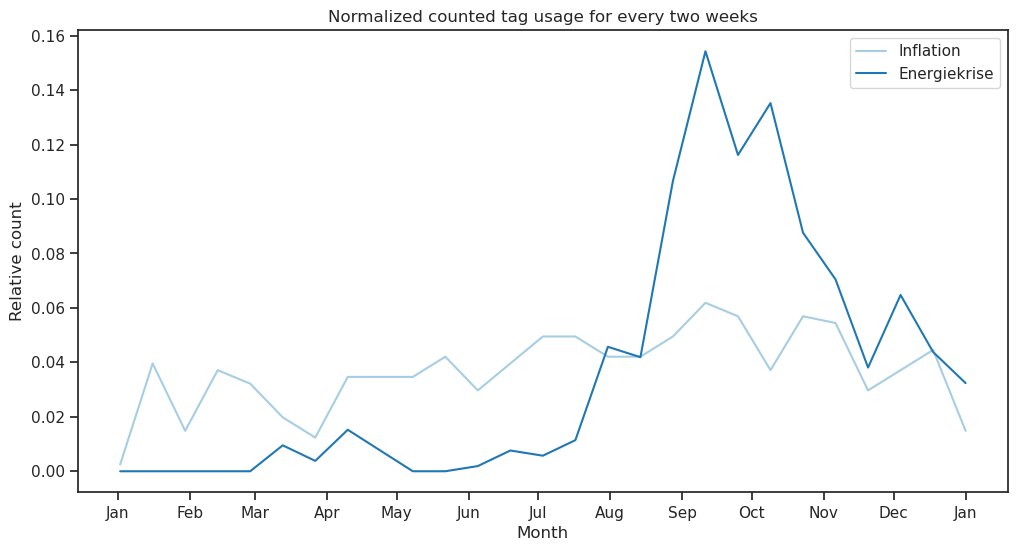

In [28]:
plot_rel_count_for_tags(df_tags_rel_occurrence[["Inflation", "Energiekrise"]])

### How are the tags correlated with respect to their occurrence (aggregated count)?

In [29]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
tag_correlation = {method: df_tags_occurrence.corr(method=method) for method in ['pearson', 'spearman']}

def plot_correlation(df_tag_correlation, method):
    plt.figure(figsize=(16, 6))
    mask = np.triu(np.ones_like(df_tag_correlation, dtype=bool))
    heatmap = sns.heatmap(df_tag_correlation, vmin=-1, vmax=1, annot=True, cmap='RdBu', mask=mask, cbar=False, fmt='.2f')
    heatmap.set_title(f'{method.title()} correlation heatmap')

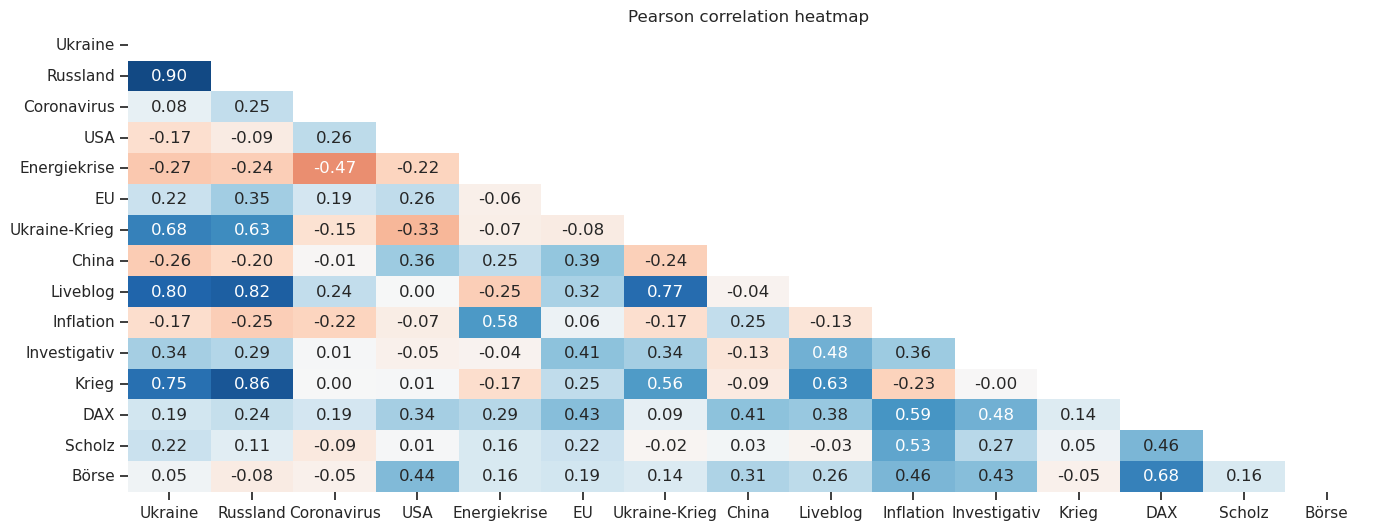

In [30]:
plot_correlation(tag_correlation['pearson'], method='pearson')
# plot_correlation(tag_correlation['spearman'], method='spearman')

In [31]:
# https://www.statology.org/numpy-get-indices-where-true/
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# https://www.scribbr.com/statistics/pearson-correlation-coefficient/
def get_correlation_pairs(df_tag_correlation):
    no_duplicated_tag_correlation = (df_tag_correlation * (np.triu(np.ones_like(df_tag_correlation, dtype=int)) - np.eye(len(df_tag_correlation), dtype=int)))
    return no_duplicated_tag_correlation.unstack().sort_values(ascending=False)

In [32]:
correlation_pairs = get_correlation_pairs(tag_correlation['pearson'])

In [33]:
correlation_pairs[correlation_pairs > 0.3]

Russland       Ukraine          0.900813
Krieg          Russland         0.855561
Liveblog       Russland         0.822163
               Ukraine          0.801562
               Ukraine-Krieg    0.768471
Krieg          Ukraine          0.751264
Ukraine-Krieg  Ukraine          0.679338
Börse          DAX              0.677401
Ukraine-Krieg  Russland         0.630331
Krieg          Liveblog         0.629989
DAX            Inflation        0.592612
Inflation      Energiekrise     0.576784
Krieg          Ukraine-Krieg    0.563917
Scholz         Inflation        0.528011
Investigativ   Liveblog         0.483218
DAX            Investigativ     0.476899
Scholz         DAX              0.457536
Börse          Inflation        0.455349
               USA              0.443530
DAX            EU               0.426546
Börse          Investigativ     0.426296
Investigativ   EU               0.409714
DAX            China            0.406582
China          EU               0.393810
DAX            L

In [34]:
correlation_pairs[correlation_pairs < -0.3]

Ukraine-Krieg  USA           -0.330775
Energiekrise   Coronavirus   -0.466783
dtype: float64

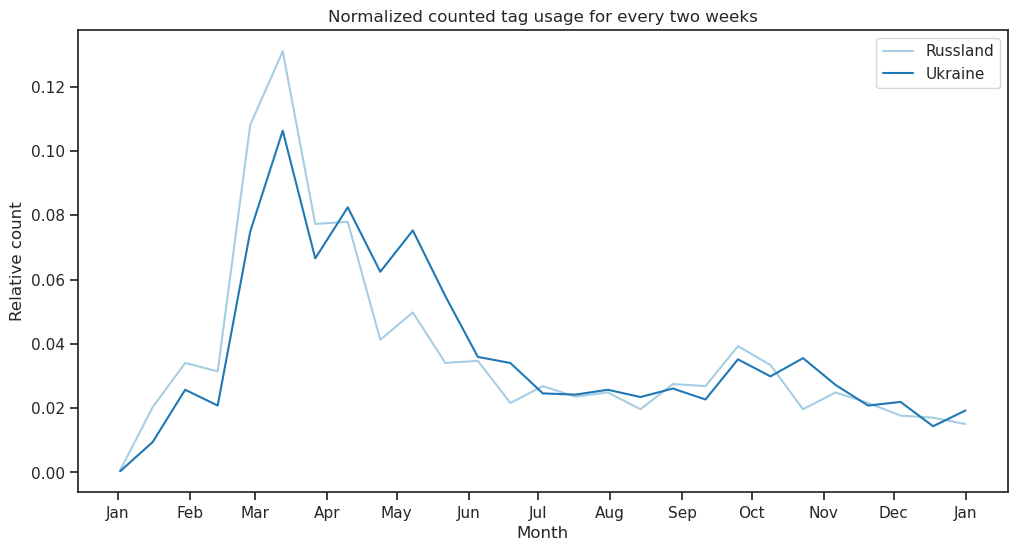

In [35]:
plot_rel_count_for_tags(df_tags_rel_occurrence[list(correlation_pairs.index[0])]) 

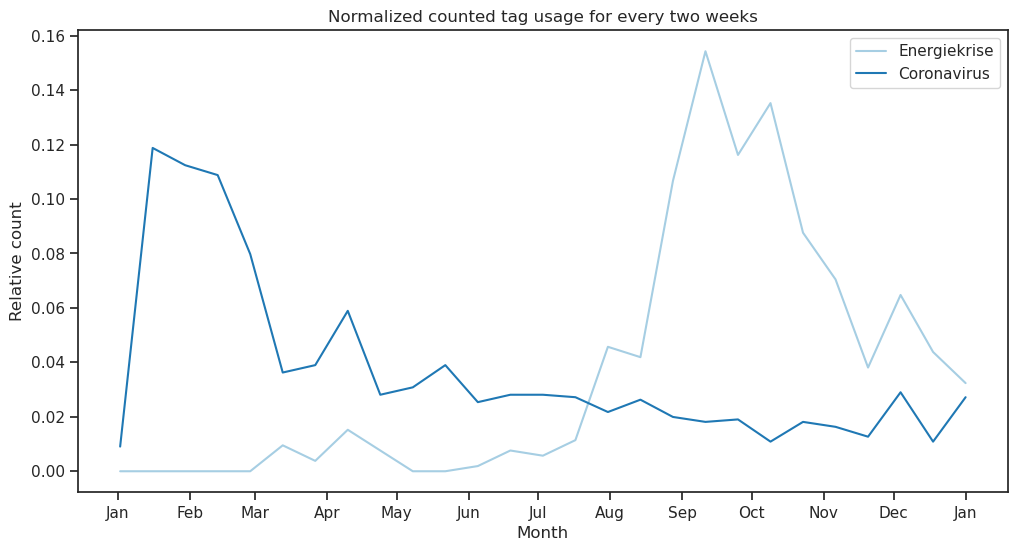

In [36]:
plot_rel_count_for_tags(df_tags_rel_occurrence[list(correlation_pairs.index[-1])])